In [7]:
import ngmix
import matplotlib.pyplot as plt
import galsim
import numpy as np

def select(data, shear_type):
    """
    select the data by shear type and size
    Parameters
    ----------
    data: array
        The array with fields shear_type and T
    shear_type: str
        e.g. 'noshear', '1p', etc.
    Returns
    -------
    array of indices
    """

    w, = np.where(
        (data['flags'] == 0) & (data['shear_type'] == shear_type)
    )
    return w

def make_struct(res, obs, shear_type):
    """
    make the data structure
    Parameters
    ----------
    res: dict
        With keys 's2n', 'e', and 'T'
    obs: ngmix.Observation
        The observation for this shear type
    shear_type: str
        The shear type
    Returns
    -------
    1-element array with fields
    """
    dt = [
        ('flags', 'i4'),
        ('shear_type', 'U7'),
        ('s2n', 'f8'),
        ('g', 'f8', 2),
        ('T', 'f8'),
        ('Tpsf', 'f8'),
    ]
    data = np.zeros(1, dtype=dt)
    data['shear_type'] = shear_type
    data['flags'] = res['flags']
    if res['flags'] == 0:
        #data['s2n'] = res['s2n']
        data['s2n'] = res['s2n']
        # for moments we are actually measureing e, the elliptity
        data['g'] = res['e']
        data['T'] = res['T']
    else:
        data['s2n'] = np.nan
        data['g'] = np.nan
        data['T'] = np.nan
        data['Tpsf'] = np.nan

        # we only have one epoch and band, so we can get the psf T from the
        # observation rather than averaging over epochs/bands
        data['Tpsf'] = obs.psf.meta['result']['T']
    return data

In [13]:
def make_data(rng, FbyB, shear, version=0, first=False, SbyN=20):
    """
    simulate an exponential object with moffat psf
    Parameters
    ----------
    rng: np.random.RandomState
        The random number generator
    noise: float
        Noise for the image
    FbyB: float
        source by background ratio
    shear: (g1, g2)
        The shear in each component
    Returns
    -------
    ngmix.Observation
    """

    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    dy, dx   = rng.uniform(low=-scale/2, high=scale/2, size=2)

    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,
    ).shear(g1=0.02, g2=-0.01,)
    
    
    obj0 = galsim.Exponential(
        half_light_radius=gal_hlr, flux=125e3
    ).shear(
        g1=shear[0],
        g2=shear[1],
    ).shift(dx=dx, dy=dy,)
    obj = galsim.Convolve(psf, obj0)

    psf_im = psf.drawImage(scale=scale).array
    im = obj.drawImage(scale = scale)
 
    # psf noise
    psf_noise= 1e-9
    psf_im += rng.normal(scale=psf_noise, size=psf_im.shape)
    
    backgrounds = []
    ngrid = im.array.shape[0]
    flux_tmp = np.sum((im.array)[ngrid//2-2:ngrid//2+3, ngrid//2-2:ngrid//2+3])
    std_tmp =  5
    F = SbyN**2.*(1+FbyB)/FbyB
    B = F/FbyB
    B_val = B/25.0
        
    im = (im/flux_tmp)*F
    
    combined_var = B_val + im
    
    
    
    
    if version==0:
        noise_image_1 = rng.normal(scale=1, size=im.array.shape)
        noise_image_1 = noise_image_1/std_tmp
        noise_image_1 *= np.sqrt(combined_var.array)
        im += noise_image_1
        
        
        #random = galsim.BaseDeviate()
        #fake_var_image = im*0 + (noise)**2
        #fakeVarNoise = galsim.VariableGaussianNoise(random, fake_var_image)
        #im.addNoise(fakeVarNoise)
        
        if first:
            backgrounds.append(noise_image_1)
            
            
    if version==1:
        
        
        random = galsim.BaseDeviate()
        var_image = im + B/25.0
        
        varNoise = galsim.VariableGaussianNoise(random, var_image)
        #varNoise.array = varNoise.array*np.sqrt(B)/std_tmp
        
        im.addNoise(varNoise)
        
        
        if first:
            backgrounds.append(var_image.array)
            
    
    imArr = im.array
    
    cen = (np.array(imArr.shape)-1.0)/2.0
    psf_cen = (np.array(psf_im.shape)-1.0)/2.0
    jacobian = ngmix.DiagonalJacobian(
        row=cen[0] + dy/scale, col=cen[1] + dx/scale, scale=scale,
    )
    psf_jacobian = ngmix.DiagonalJacobian(
        row=psf_cen[0], col=psf_cen[1], scale=scale,
    )

    # noise variance map
    if version==0:
        #wt = imArr*0 + 1.0/(noise)**2
        #wt = (im.array)*0 + 25.0/B
        wt = 1.0/combined_var.array
    if version==1:
        wt = 1.0/var_image.array
        
    psf_wt = psf_im*0 + 1.0/psf_noise**2

    psf_obs = ngmix.Observation(
        psf_im,
        weight=psf_wt,
        jacobian=psf_jacobian,
    )
    obs = ngmix.Observation(
        imArr,
        weight=wt,
        jacobian=jacobian,
        psf=psf_obs,
    )
    return obs, backgrounds

In [9]:
#def analyze(rng, num_tests, num_gals, noise_level, shear_true, version=0, first=False):
def analyze(rng, num_tests, num_gals, FBratioArr, shear_true, version=0, first=False, SbyN=20):
    data = []
    x = []
    y = []
    shear_error = []
    s2n_error = []
    backgrounds = []
    
    for i in range(num_tests):
        print("len(data[]) =", len(data))
        dlist = []
        
        #makes first true for every new noise value
        if first is False:
            first = True
        
        for j in range(num_gals):
            #imgdata = make_data(rng=rng, noise=noise_level[i], shear=shear_true, version=version, first = first)
            imgdata = make_data(rng=rng, FbyB=FBratioArr[i], shear=shear_true, version=version, first=first, SbyN=20)
            obs = imgdata[0]
            
            if(len(imgdata[1]) > 0):
                backgrounds.append(imgdata[1][0])
                
                            
            if first is True:
                first = False
                
            resdict, obsdict = boot.go(obs)
            for stype, sres in resdict.items():
                st = make_struct(res=sres, obs=obsdict[stype], shear_type=stype)
                dlist.append(st)
                
        data.append(np.hstack(dlist))
        #data contains average of all galaxy data
        
        w = select(data=data[i], shear_type='noshear')
        w_1p = select(data=data[i], shear_type='1p')
        w_1m = select(data=data[i], shear_type='1m')
        g_1p = data[i]['g'][w_1p, 0].mean()
        g_1m = data[i]['g'][w_1m, 0].mean()
        R11 = (g_1p - g_1m)/0.02
        
        #s2n = data[i]['s2n'][w].mean()
        #s2n_err = data[i]['s2n'][w].std(axis=0)/np.sqrt(w.size)
        #s2n_error.append(s2n_err)
        
        
        g = data[i]['g'][w].mean(axis=0)
        shear = g / R11
        
        g_error = data[i]['g'][w].std(axis=0) / np.sqrt(w.size)
        shear_error.append(g_error[0]/R11)
        
        #x.append(s2n)
        x.append(FBratioArr[i])
        y.append(shear[0])
            
    return (x, y, s2n_error, shear_error, backgrounds)

In [10]:
rng = np.random.RandomState(1024)
#rng = galsim.BaseDeviate(1024)

# We will measure moments with a fixed gaussian weight function
weight_fwhm= 1.2
fitter     = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)
psf_fitter = ngmix.gaussmom.GaussMom(fwhm=weight_fwhm)

# these "runners" run the measurement code on observations
psf_runner = ngmix.runners.PSFRunner(fitter=psf_fitter)
runner     = ngmix.runners.Runner(fitter=fitter)

# this "bootstrapper" runs the metacal image shearing as well as both psf
# and object measurements
#
# We will just do R11 for simplicity and to speed up this example;
# typically the off diagonal terms are negligible, and R11 and R22 are
# usually consistent
boot      = ngmix.metacal.MetacalBootstrapper(
    runner= runner, psf_runner=psf_runner,
    rng=rng,
    psf='gauss',
    types=['noshear', '1p', '1m'],
)

len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
x = [0.001, 0.01, 0.1, 1.0, 10.0]
y = [0.04170138237518228, 0.0365268459043839, 0.031511810242003044, 0.027446770018786835, 0.040243582608271454]
xerr = []
yerr = [0.011503278188112047, 0.012333662635662549, 0.01143353243834893, 0.008984184577493433, 0.008837159260842522]


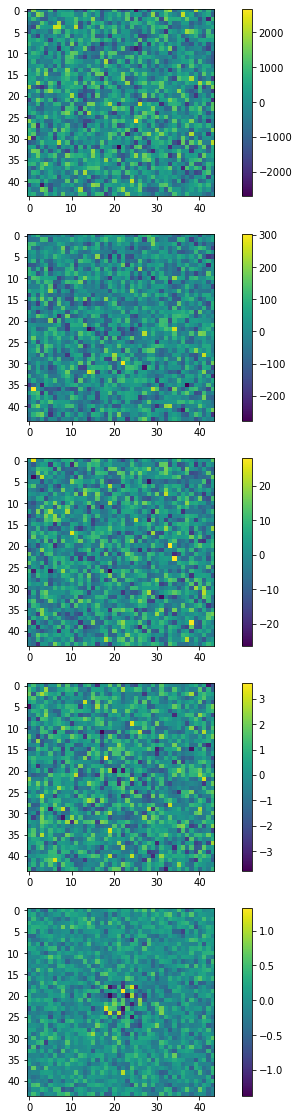

In [11]:
#noise_arr = 1e5*np.logspace(-4, -2, 5, base=10.0)
FBratioArr = np.logspace(start=-3,stop=1,num=5, base=10)
num_tests = len(FBratioArr)
num_gals = 100
shear_true = [0.03, 0.00]
#ans1 = analyze(rng, num_tests, num_gals, noise_arr, shear_true, version=0, first = True)
ans1 = analyze(rng, num_tests, num_gals, FBratioArr, shear_true, version=0, first=True, SbyN=20)
backgrounds = ans1[4]
print("x =", ans1[0])
print("y =", ans1[1])
print("xerr =", ans1[2])
print("yerr =", ans1[3])
plt.close()
fig = plt.figure(figsize=(10, 20))

for i in range(len(backgrounds)):
    sub = fig.add_subplot(len(backgrounds), 1, i + 1)
    plot = sub.imshow(backgrounds[i])
    fig.colorbar(plot)

len(data[]) = 0
len(data[]) = 1
len(data[]) = 2
len(data[]) = 3
len(data[]) = 4
x = [0.001, 0.01, 0.1, 1.0, 10.0]
y = [-0.02335435088221397, 0.04456785241432318, 0.008843573546193027, 0.03891119111291637, 0.03489887912789484]
yerr = [0.017024669422884157, 0.01728684275631034, 0.015913827023491603, 0.013627017439465743, 0.010577577161034309]


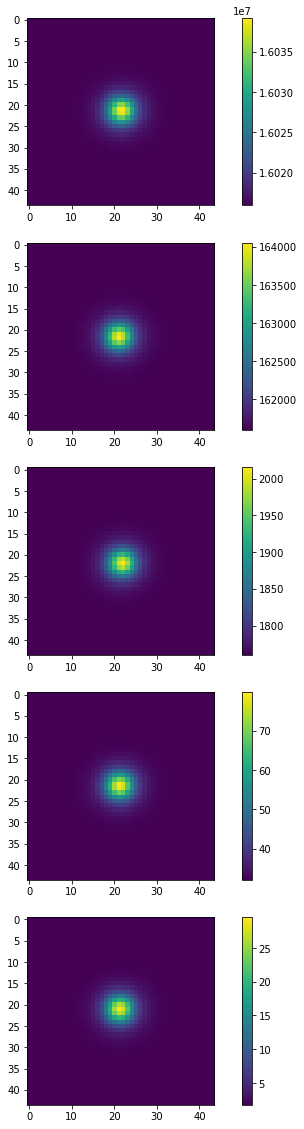

In [14]:
ans2 = analyze(rng, num_tests, num_gals, FBratioArr, shear_true, version=1, first = True, SbyN=20)
backgrounds = ans2[4]
print("x =", ans2[0])
print("y =", ans2[1])
#print("xerr =", ans2[2])
print("yerr =", ans2[3])

fig = plt.figure(figsize=(10, 20))

for i in range(len(backgrounds)):
    sub = fig.add_subplot(len(backgrounds), 1, i + 1)
    plot = sub.imshow(backgrounds[i])
    fig.colorbar(plot)

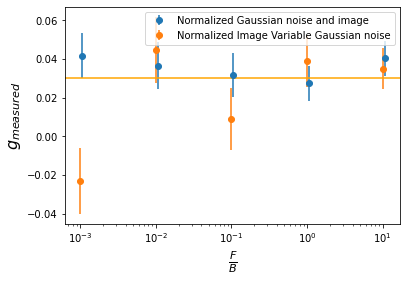

In [15]:
#plt.errorbar(ans1[0], ans1[1], xerr=ans1[2], yerr=ans1[3], fmt='o', label='background only')
plt.errorbar(np.array(ans1[0])*1.06, ans1[1], yerr=ans1[3], fmt='o', label='Normalized Gaussian noise and image')
plt.errorbar(ans2[0], ans2[1], yerr=ans2[3], fmt='o', label='Normalized Image Variable Gaussian noise')
plt.axhline(shear_true[0], color="orange")
plt.xscale("log")
plt.xlabel(r'$\frac{F}{B}$', fontsize=16)
plt.ylabel(r'$g_{measured}$', fontsize=16)
plt.legend()

In [39]:
"""
im_noiseNormal = im
im_noiseVariable = im
galList.append(im_noiseNormal.array)
galList.append(im_noiseVariable.array)
galList.append(im.array)
for i in range(3):
    plt.imshow(galList[i])
    
plt.plot(im_noiseNormal)
plt.plot(im_noiseVariable.array)
plt.plot(im.array)

plt.show()
"""


def drawGal(pick):
    
    scale    = 0.263
    psf_fwhm = 0.9
    gal_hlr  = 0.5
    noise = 0.001
    random = galsim.BaseDeviate(1000)
    
    psf = galsim.Moffat(beta=2.5, fwhm=psf_fwhm,).shear(g1=0, g2=0,)
    
    
    obj0 = galsim.Exponential(half_light_radius=gal_hlr)
    
    obj = galsim.Convolve(psf, obj0)

    im = obj.drawImage(scale=scale)
    image = im

    """
    if(pick == 1):
        im += rng.normal(scale=noise, size=im.array.shape)
    if(pick == 4):
    gaussian_noise = galsim.GaussianNoise(random, sigma=noise*3)
    im.addNoise(gaussian_noise)
    """
        
    if(pick == 2):
        var_image= im + (noise)**2
        #varNoise = galsim.VariableGaussianNoise(random, var_image)
        #im.addNoise(varNoise)
        image = var_image

    if(pick == 3):
        other_var_image = im*0 + (noise)**2
        #otherVarNoise = galsim.VariableGaussianNoise(random, other_var_image)
        #im.addNoise(otherVarNoise)
        image = other_var_image
        
    
    return(plt.imshow(image.array), plt.colorbar())

(<matplotlib.image.AxesImage at 0x12f2566a0>,
 <matplotlib.colorbar.Colorbar at 0x12f270970>)

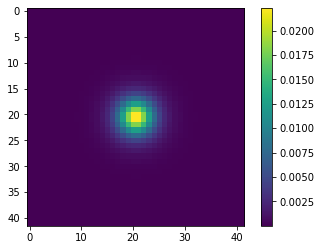

In [59]:
drawGal(0)

(<matplotlib.image.AxesImage at 0x12f396e80>,
 <matplotlib.colorbar.Colorbar at 0x12f3bb220>)

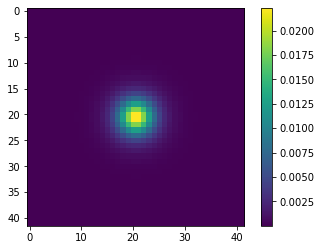

In [60]:
drawGal(2)

(<matplotlib.image.AxesImage at 0x12f4e38b0>,
 <matplotlib.colorbar.Colorbar at 0x12f4feb50>)

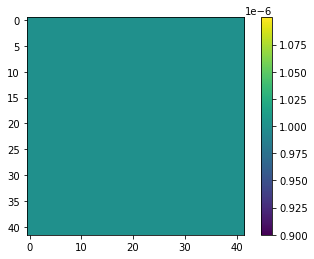

In [61]:
drawGal(3)